# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df

,Open
Date,
2020-06-01,0.94545
2020-06-02,1.01907
2020-06-03,0.95270
2020-06-04,0.96672
2020-06-05,0.97940
...,...
2022-05-28,2.86201
2022-05-29,2.90271
2022-05-30,2.94652


In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['Open'].values.reshape(-1, 1)
df.head()

df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [4]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = LR_sc.fit_transform(df_open)
df_scaled

,Open,Timestamp
Date,,
2020-06-01,-1.566754,1.590970e+09
2020-06-02,-1.522736,1.591056e+09
2020-06-03,-1.562419,1.591142e+09
2020-06-04,-1.554036,1.591229e+09
2020-06-05,-1.546455,1.591315e+09
...,...,...
2022-05-28,-0.420844,1.653696e+09
2022-05-29,-0.396509,1.653782e+09
2022-05-30,-0.370315,1.653869e+09


## Vẽ đồ thị

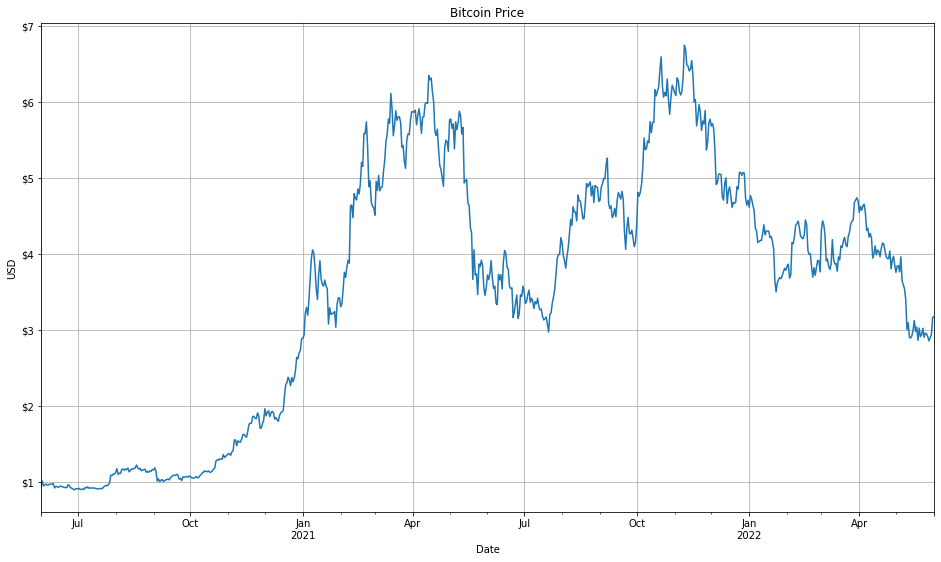

In [5]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [6]:
df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [7]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Open'] = y_scaled
df_scaled.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729683,-1.566754
2020-06-02,-1.724944,-1.522736
2020-06-03,-1.720205,-1.562419
2020-06-04,-1.715466,-1.554036
2020-06-05,-1.710728,-1.546455


## Chia tập dữ liệu

In [8]:
interrupt = int(len(df_scaled) * .7)
interrupt


511

In [9]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(511, 2)
(220, 2)


In [10]:
train_data.tail()

,Timestamp,Open
Date,,
2021-10-20,0.668179,1.711075
2021-10-21,0.672918,1.814374
2021-10-22,0.677657,1.586945
2021-10-23,0.682395,1.496805
2021-10-24,0.687134,1.533576


In [11]:
test_data.head()

,Timestamp,Open
Date,,
2021-10-25,0.691873,1.507035
2021-10-26,0.696612,1.638765
2021-10-27,0.701351,1.474043
2021-10-28,0.706090,1.361919
2021-10-29,0.710829,1.490031


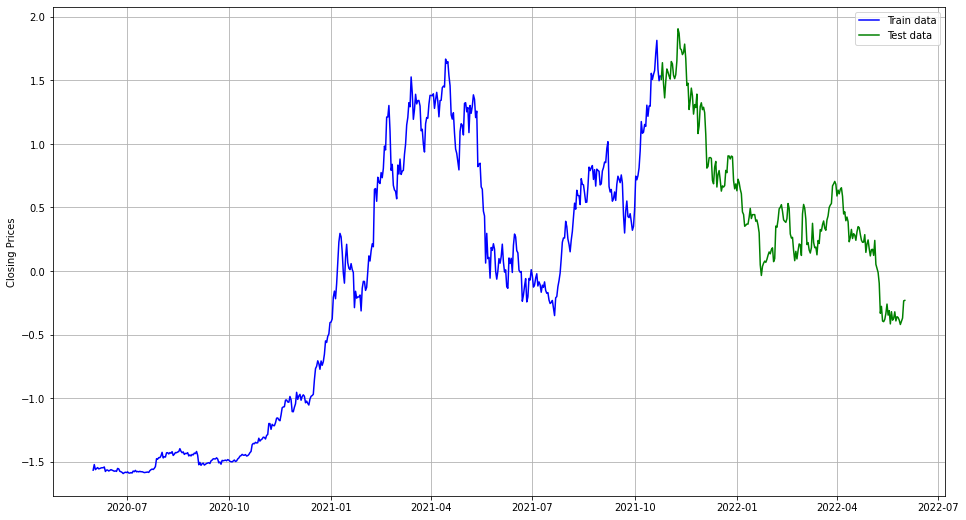

In [12]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Open'], 'blue', label='Train data')
plt.plot(test_data['Open'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Open




In [13]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Open'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Open'].values.reshape(-1, 1)


In [14]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [15]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

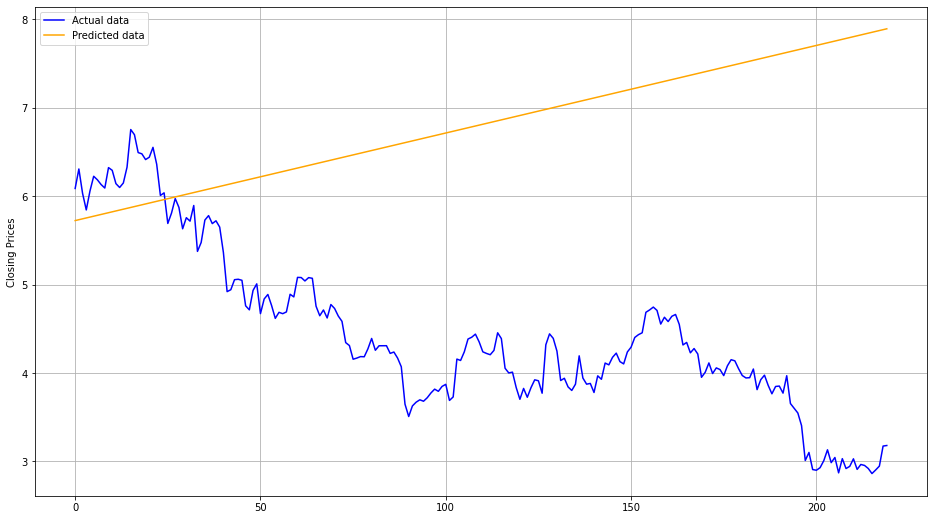

In [16]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [17]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.46
MAPE: 63.88%
MSE: 7.85
RMSE: 2.80
R2: -8.07


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [18]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2021-10-25,6.08643,5.723229,0.363201
2021-10-26,6.30675,5.733133,0.573617
2021-10-27,6.03125,5.743038,0.288212
2021-10-28,5.84372,5.752942,0.090778
2021-10-29,6.05799,5.762847,0.295143
...,...,...,...
2022-05-28,2.86201,7.852681,-4.990671
2022-05-29,2.90271,7.862586,-4.959876
2022-05-30,2.94652,7.872490,-4.925970


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [19]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2021-10-25,6.08643,5.723229,0.363201
2021-10-26,6.30675,5.733133,0.573617
2021-10-27,6.03125,5.743038,0.288212
2021-10-28,5.84372,5.752942,0.090778
2021-10-29,6.05799,5.762847,0.295143
...,...,...,...
2022-05-28,2.86201,7.852681,-4.990671
2022-05-29,2.90271,7.862586,-4.959876
2022-05-30,2.94652,7.872490,-4.925970


## Vẽ đồ thị thể hiện sai số

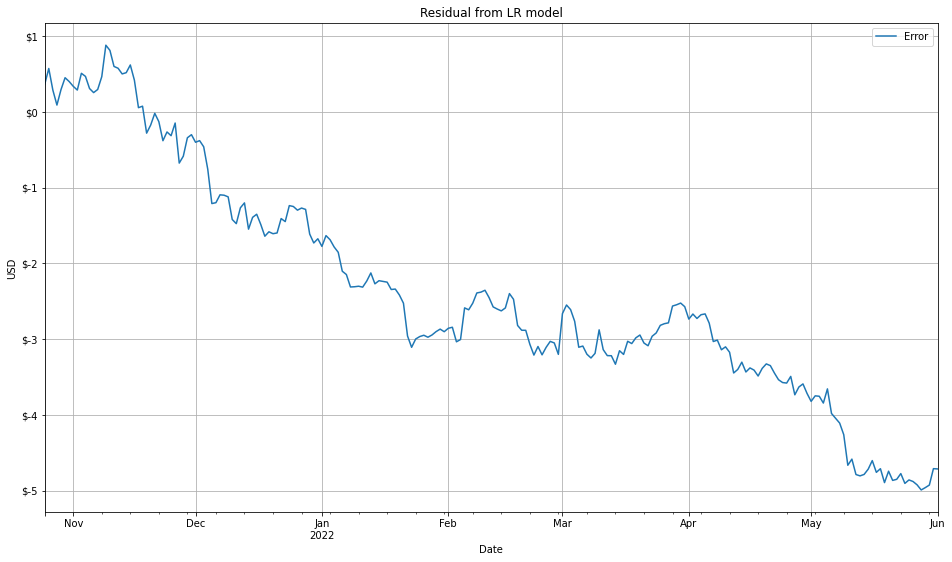

In [20]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [21]:
error = np.array(error)
error

array([[ 0.36320116],
       [ 0.57361674],
       [ 0.28821231],
       [ 0.09077788],
       [ 0.29514345],
       [ 0.45174902],
       [ 0.40156459],
       [ 0.33845016],
       [ 0.28875573],
       [ 0.5099813 ],
       [ 0.46926687],
       [ 0.30897244],
       [ 0.25523801],
       [ 0.29639359],
       [ 0.46574916],
       [ 0.88107473],
       [ 0.8125603 ],
       [ 0.60067587],
       [ 0.57675144],
       [ 0.50191701],
       [ 0.51840258],
       [ 0.62026815],
       [ 0.41938372],
       [ 0.05638929],
       [ 0.07588486],
       [-0.28000956],
       [-0.17266399],
       [-0.01824842],
       [-0.12858285],
       [-0.37997728],
       [-0.26442171],
       [-0.31355614],
       [-0.14644057],
       [-0.675355  ],
       [-0.58417943],
       [-0.34107386],
       [-0.30026828],
       [-0.40052271],
       [-0.37881714],
       [-0.45998157],
       [-0.757336  ],
       [-1.20967043],
       [-1.19800486],
       [-1.09437929],
       [-1.09936372],
       [-1

In [22]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (217, 3, 1)
y_train (217, 1)


In [23]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
7/7 [==============================] - 7s 11ms/step - loss: 7.3630
Epoch 2/300
7/7 [==============================] - 0s 9ms/step - loss: 6.6288
Epoch 3/300
7/7 [==============================] - 0s 11ms/step - loss: 5.6158
Epoch 4/300
7/7 [==============================] - 0s 10ms/step - loss: 3.9962
Epoch 5/300
7/7 [==============================] - 0s 10ms/step - loss: 1.6357
Epoch 6/300
7/7 [==============================] - 0s 13ms/step - loss: 0.6420
Epoch 7/300
7/7 [==============================] - 0s 13ms/step - loss: 0.4475
Epoch 8/300
7/7 [==============================] - 0s 12ms/step - loss: 0.3460
Epoch 9/300
7/7 [==============================] - 0s 15ms/step - loss: 0.3159
Epoch 10/300
7/7 [==============================] - 0s 11ms/step - loss: 0.2297
Epoch 11/300
7/7 [==============================] - 0s 14ms/step - loss: 0.2086
Epoch 12/300
7/7 [==============================] - 0s 12ms/step - loss: 0.1723
Epoch 13/300
7/7 [==============================] 

In [24]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[ 0.15477824],
       [ 0.14889334],
       [ 0.40016952],
       [ 0.4749164 ],
       [ 0.3533101 ],
       [ 0.3347756 ],
       [ 0.30960706],
       [ 0.56826913],
       [ 0.38885292],
       [ 0.26760256],
       [ 0.29568774],
       [ 0.35044134],
       [ 0.51021534],
       [ 0.8507027 ],
       [ 0.5569642 ],
       [ 0.53855443],
       [ 0.6032142 ],
       [ 0.4393713 ],
       [ 0.51031435],
       [ 0.5817905 ],
       [ 0.28444487],
       [ 0.08199888],
       [ 0.15228258],
       [-0.24459131],
       [-0.14638768],
       [-0.10437395],
       [-0.18071054],
       [-0.36783883],
       [-0.3215609 ],
       [-0.4197911 ],
       [-0.26998273],
       [-0.710581  ],
       [-0.6190483 ],
       [-0.43660006],
       [-0.39796278],
       [-0.5046472 ],
       [-0.49735814],
       [-0.57231736],
       [-0.8640114 ],
       [-1.2018495 ],
       [-1.2365798 ],
       [-1.1607109 ],
       [-1.1739006 ],
       [-1.19031   ],
       [-1.4407257 ],
       [-1

In [25]:
df_lstm

,Actual,Pred,Error
Date,,,
2021-10-25,6.08643,5.723229,0.363201
2021-10-26,6.30675,5.733133,0.573617
2021-10-27,6.03125,5.743038,0.288212
2021-10-28,5.84372,5.752942,0.090778
2021-10-29,6.05799,5.762847,0.295143
...,...,...,...
2022-05-28,2.86201,7.852681,-4.990671
2022-05-29,2.90271,7.862586,-4.959876
2022-05-30,2.94652,7.872490,-4.925970


In [26]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2021-10-25,6.08643,5.723229,0.363201,0.154778
2021-10-26,6.30675,5.733133,0.573617,0.148893
2021-10-27,6.03125,5.743038,0.288212,0.400170
2021-10-28,5.84372,5.752942,0.090778,0.474916
2021-10-29,6.05799,5.762847,0.295143,0.353310
...,...,...,...,...
2022-05-25,2.96487,7.822968,-4.858098,-4.886758
2022-05-26,2.95379,7.832872,-4.879082,-4.938232
2022-05-27,2.91940,7.842777,-4.923377,-4.918186


In [27]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2021-10-25,6.08643,5.723229,0.363201,0.154778,5.878007
2021-10-26,6.30675,5.733133,0.573617,0.148893,5.882027
2021-10-27,6.03125,5.743038,0.288212,0.400170,6.143207
2021-10-28,5.84372,5.752942,0.090778,0.474916,6.227859
2021-10-29,6.05799,5.762847,0.295143,0.353310,6.116157
...,...,...,...,...,...
2022-05-25,2.96487,7.822968,-4.858098,-4.886758,2.936210
2022-05-26,2.95379,7.832872,-4.879082,-4.938232,2.894640
2022-05-27,2.91940,7.842777,-4.923377,-4.918186,2.924590


## Vẽ đồ thị

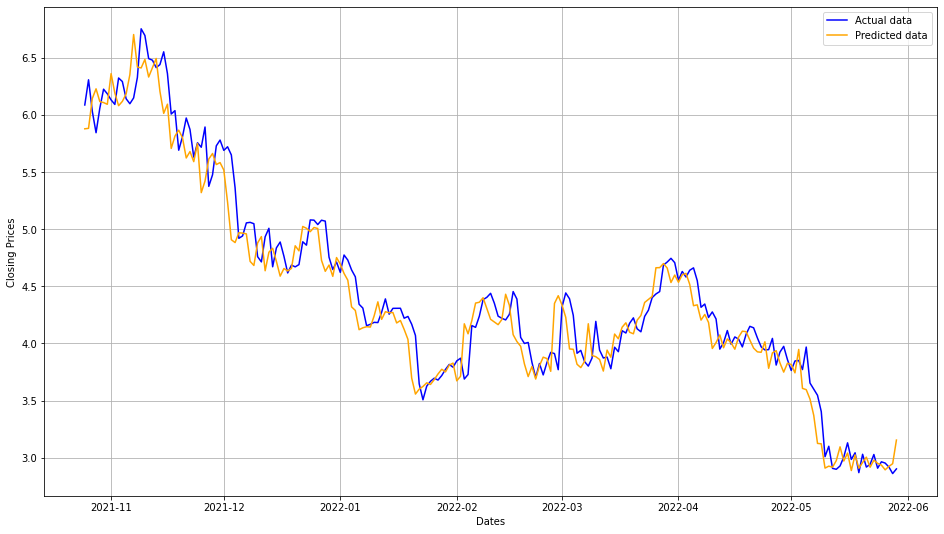

In [28]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [29]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.16
MAPE: 3.46%
MSE: 0.04
RMSE: 0.21
R2: -8.07


## Lấy 3 ngày cuối ra để dự báo

In [30]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -4.923377
2022-05-28   -4.990671
2022-05-29   -4.959876
Name: Error, dtype: float64

## Đưa về ma trận

In [31]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-4.92337668],
        [-4.9906711 ],
        [-4.95987553]]])

In [32]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-4.9181867], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [33]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.90271,7.862586,-4.959876


In [34]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.90271,7.862586,-4.959876,2.944399


## Ghi ra file csv

In [35]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")